In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import files
import os, shutil, pathlib

In [2]:
# Upload Kaggle API to download dataset
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soham0017","key":"0c2a94d5bb63ff3b27bc6288d658ce40"}'}

In [3]:
!mkdir ~/.kaggle # create a ~/.kaggle folder
!cp kaggle.json ~/.kaggle/ # copy the key file to it
!chmod 600 ~/.kaggle/kaggle.json # file is only readable by current user, yourself

!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:38<00:00, 23.5MB/s]
100% 812M/812M [00:38<00:00, 22.1MB/s]


In [4]:
# uncompressing it quietly
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
# copying images to training, validation, and test directories

original_dir = pathlib.Path("train") # path to directory with original dataset
new_base_dir = pathlib.Path("cats_vs_dogs_small") # directory where we will store our smaller dataset

"""
we will use smaller dataset (train size = 1000) because in real world problem, we
might not get dataset of this size(25000)
"""


'\nwe will use smaller dataset (train size = 1000) because in real world problem, we\nmight not get dataset of this size(25000)\n'

In [7]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)

In [8]:
# Data preprocessing {
    # reading pictures
    # dcode jpeg content to rgb grid of pixels
    # convert these to floating-point tensors
    # resize them
    # pack them into batches } all this using ... image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size = (180, 180), batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size = (180, 180), batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size = (180, 180), batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
# output of one of these dataset objects
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape )
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
# Data Augmentation : with small datset chances of overfitting are high therefore...
data_augmentation = keras.Sequential(
     [
         layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.1),
         layers.RandomZoom(0.2),
     ]
 )

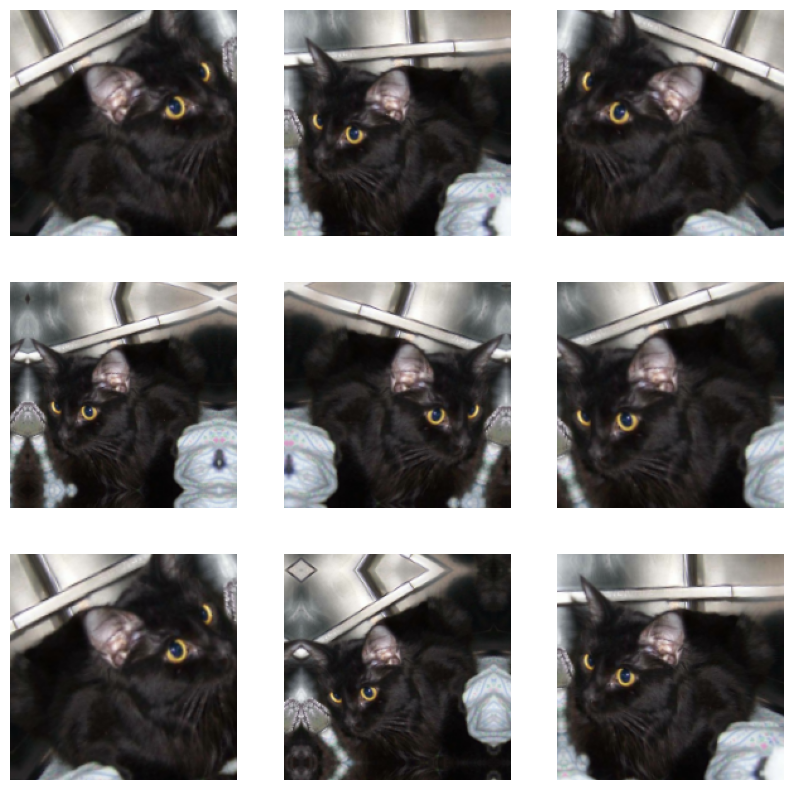

In [ ]:
plt.figure(figsize = (10,10))
for images, _ in train_dataset.take(14):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[30].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Building the model

inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./ 255)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPool2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/100
63/63 [==============================] - 15s 88ms/step - loss: 0.7016 - accuracy: 0.4925 - val_loss: 0.6919 - val_accuracy: 0.5120
Epoch 2/100
63/63 [==============================] - 5s 72ms/step - loss: 0.7030 - accuracy: 0.5190 - val_loss: 0.6899 - val_accuracy: 0.5020
Epoch 3/100
63/63 [==============================] - 7s 106ms/step - loss: 0.6913 - accuracy: 0.5545 - val_loss: 0.6649 - val_accuracy: 0.5970
Epoch 4/100
63/63 [==============================] - 4s 65ms/step - loss: 0.7102 - accuracy: 0.5855 - val_loss: 0.6454 - val_accuracy: 0.6290
Epoch 5/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6373 - accuracy: 0.6195 - val_loss: 1.2189 - val_accuracy: 0.5170
Epoch 6/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6421 - accuracy: 0.6390 - val_loss: 0.6341 - val_accuracy: 0.6050
Epoch 7/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6188 - accuracy: 0.6475 - val_loss: 0.6229 - val_accuracy: 0.6380
Epoc

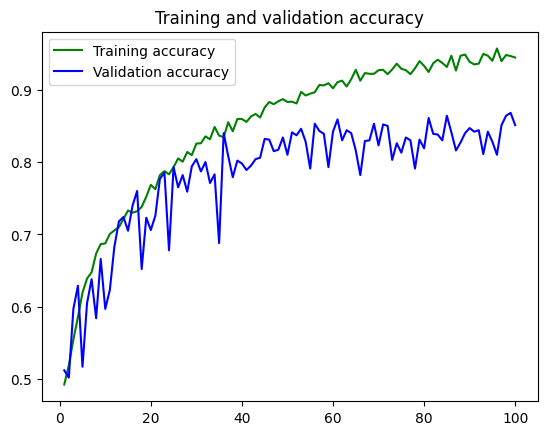

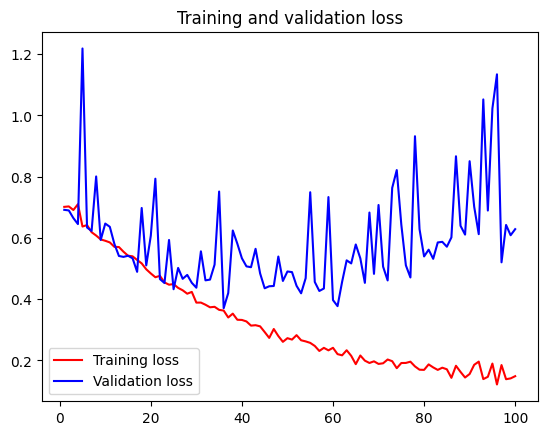

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "g", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 0.4164 - accuracy: 0.8225
Test accuracy:0.822


# **Using Pretrained Network - VGG16**

Method 1 : Feature Extraction without data augmentation

In [33]:
#Instantiating the VGG16 Convolutional base

conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet", # weight checkpoints from which to initialize the model
    include_top = False, # not include densely connected classifier on top of network
    input_shape = (180, 180, 3)
)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [11]:
# Extracting VGG16 features and corresponding labels

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

print(train_features.shape)

1/1 [==============================] - 0s 31ms/step
(2000, 5, 5, 512)


In [13]:
inputs = keras.Input(shape=(5,5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = keras.Model(inputs, outputs)

In [16]:
model_2.compile(
    loss = "binary_crossentropy",
    optimizer = "rmsprop",
    metrics = ["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]
history = model_2.fit(
    train_features, train_labels,
    epochs = 20,
    validation_data = (val_features, val_labels),
    callbacks = callbacks
)

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 14.1434 - accuracy: 0.9180 - val_loss: 4.3330 - val_accuracy: 0.9620
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 2.6493 - accuracy: 0.9795 - val_loss: 7.3105 - val_accuracy: 0.9580
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.9834 - accuracy: 0.9850 - val_loss: 8.2893 - val_accuracy: 0.9540
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9506 - accuracy: 0.9895 - val_loss: 2.7419 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0334 - accuracy: 0.9935 - val_loss: 4.3220 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5829 - accuracy: 0.9930 - val_loss: 5.9854 - val_accuracy: 0.9680
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.9960 - val_loss: 4.0338 - val_accuracy: 0.9750
Epoch 8/20
63/63 [

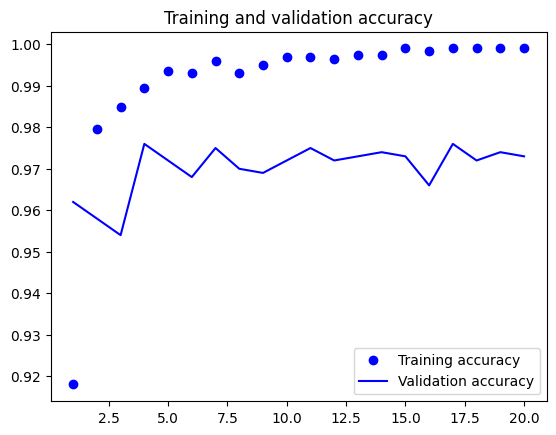

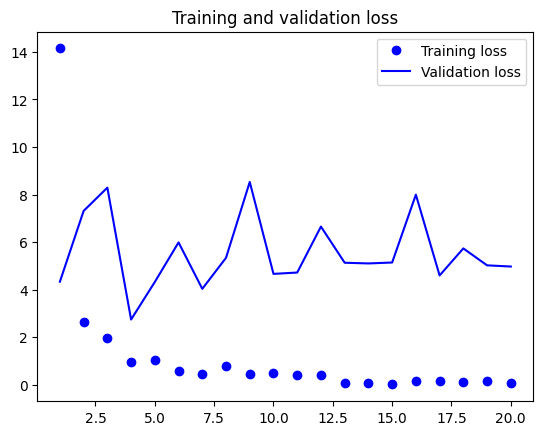

In [18]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Method 2 : Feature Extraction with data augmentation

In [9]:
conv_base_2  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base_2.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [34]:
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [10]:
data_augmentation = keras.Sequential(
  [
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
  ]
)

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base_2(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = keras.Model(inputs, outputs)

In [39]:
model_3.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model_3.fit(
    train_dataset,
    epochs=50,
    validation_data = validation_dataset,
    callbacks = callbacks
)


Epoch 1/50
63/63 [==============================] - 12s 157ms/step - loss: 21.2593 - accuracy: 0.8955 - val_loss: 12.1186 - val_accuracy: 0.9330
Epoch 2/50
63/63 [==============================] - 12s 186ms/step - loss: 7.4526 - accuracy: 0.9335 - val_loss: 5.3982 - val_accuracy: 0.9670
Epoch 3/50
63/63 [==============================] - 10s 155ms/step - loss: 4.7167 - accuracy: 0.9575 - val_loss: 4.0112 - val_accuracy: 0.9690
Epoch 4/50
63/63 [==============================] - 10s 154ms/step - loss: 4.7896 - accuracy: 0.9625 - val_loss: 7.9062 - val_accuracy: 0.9600
Epoch 5/50
63/63 [==============================] - 29s 461ms/step - loss: 4.1285 - accuracy: 0.9695 - val_loss: 3.8953 - val_accuracy: 0.9730
Epoch 6/50
63/63 [==============================] - 9s 144ms/step - loss: 3.9192 - accuracy: 0.9665 - val_loss: 4.1273 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 10s 153ms/step - loss: 2.5258 - accuracy: 0.9725 - val_loss: 4.5630 - val_accuracy: 0.971

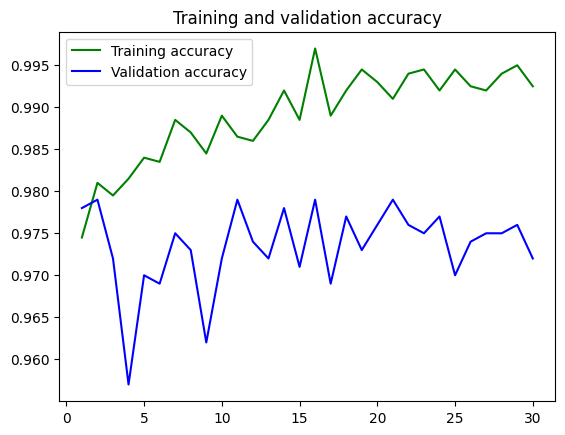

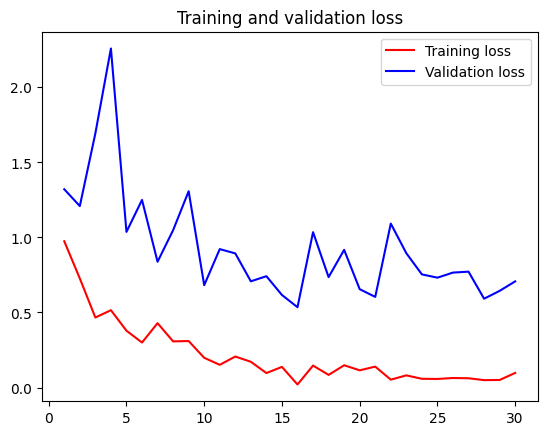

In [46]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "g", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [42]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras",
    safe_mode = False)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 90ms/step - loss: 1.8515 - accuracy: 0.9745
Test accuracy: 0.975


Method 3 : Fine tuning

In [11]:
# Freezing all layers until the fourth from the last
conv_base_2.trainable = True
for layer in conv_base_2.layers[:-4]:
  layer.trainable = False

In [14]:
model_3.compile(loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]

history = model_3.fit(
  train_dataset,
  epochs=30,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 28s 251ms/step - loss: 3.8810 - accuracy: 0.7320 - val_loss: 0.6640 - val_accuracy: 0.9140
Epoch 2/30
63/63 [==============================] - 11s 165ms/step - loss: 1.0971 - accuracy: 0.8665 - val_loss: 0.3765 - val_accuracy: 0.9490
Epoch 3/30
63/63 [==============================] - 11s 176ms/step - loss: 0.5714 - accuracy: 0.9035 - val_loss: 0.2808 - val_accuracy: 0.9600
Epoch 4/30
63/63 [==============================] - 12s 181ms/step - loss: 0.3370 - accuracy: 0.9280 - val_loss: 0.2409 - val_accuracy: 0.9670
Epoch 5/30
63/63 [==============================] - 12s 180ms/step - loss: 0.2330 - accuracy: 0.9435 - val_loss: 0.2192 - val_accuracy: 0.9690
Epoch 6/30
63/63 [==============================] - 12s 176ms/step - loss: 0.2464 - accuracy: 0.9470 - val_loss: 0.1912 - val_accuracy: 0.9680
Epoch 7/30
63/63 [==============================] - 13s 206ms/step - loss: 0.1994 - accuracy: 0.9480 - val_loss: 0.1846 - val_accuracy: 0.9710

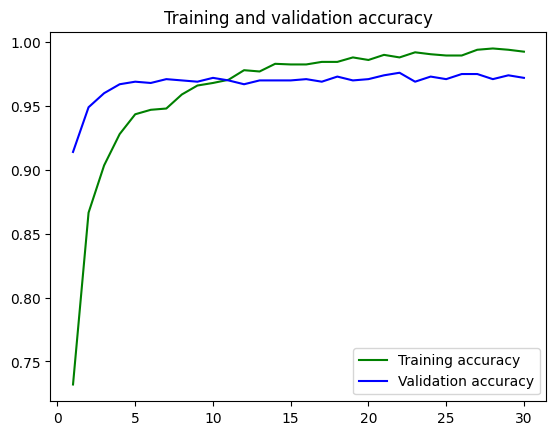

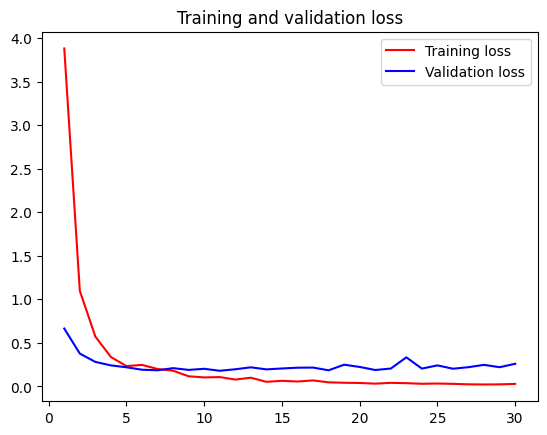

In [15]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "g", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
model = keras.models.load_model("fine_tuning.keras",safe_mode = False)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 92ms/step - loss: 0.1548 - accuracy: 0.9700
Test accuracy: 0.970
